In [1]:
#@title Student Information
#@markdown Enter the following info and run the cell:
Name = "Ali Sedaghi" #@param {type:"string"}
StudentNumber = 97521378 #@param {type:"integer"}

#Imports

In [2]:
%%capture
!pip install transformers

In [3]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_datasets as tfds

from functools import reduce
import tarfile
import numpy as np
import re

import IPython
from IPython.display import clear_output 
import matplotlib.pyplot as plt
import pandas as pd

from transformers import TFBertModel, BertTokenizer
%matplotlib inline

In [4]:
!nvidia-smi # check if gpu mode is selected

Thu Jan  6 15:17:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We will use a dataset consists of questions where a previously given single supporting fact, potentially amongst a set of other irrelevant facts, provides the answer. We first test one of the simplest cases of this, by asking for the location of a person, e.g. “$Mary$ $travelled$ $to$ $the$ $office.$ $Where$ $is$ $Mary?$”. It can be considered the
simplest case of some real world QA datasets.

About the dataset: https://research.fb.com/downloads/babi/

Lets download the dataset:

# 1. LSTM- Q&A



## 1.2 Preprocessing

Our model takes a discrete set of inputs $x_{1}, ..., x_{n}$ that are to be stored in the memory, a query $q$, and outputs an answer $a$. Each of the $x_{i}$, $q$, and $a$ contains symbols coming from a dictionary with $V$ words. The model writes all $x$ to the memory up to a fixed buffer size, and then finds a continuous representation for the $x$ and $q$. The continuous representation is then processed via multiple hops to
output $a$. This allows backpropagation of the error signal through multiple memory accesses back to the input during training. The overall model is shown in the next figure. During training, all three embedding matrices $A, B$ and $C$, as well as $W$ are jointly learned by minimizing a standard cross-entropy loss between $aˆ$ and the true
label $a$. Training is performed using stochastic gradient descent.


Delve more deeply into the details: https://arxiv.org/pdf/1503.08895.pdf

In [5]:
%%capture
!wget https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz
!tar -xvzf babi_tasks_1-20_v1-2.tar.gz

In [6]:
challenges = [
    'qa1_single-supporting-fact',
    'qa2_two-supporting-facts',
]
train_file_path = f'/content/tasks_1-20_v1-2/en-10k/{challenges[0]}_train.txt'
test_file_path = f'/content/tasks_1-20_v1-2/en-10k/{challenges[0]}_test.txt'

In [7]:
def word_tokenizer(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x.strip()]

According to the dataset (bAbi tasks), we need to prepare the data for training the model. With the next function we parse the dataset and manufactore it in desired way.

In [8]:
def parse_stories(lines, only_supporting=False, tokenize = True):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            if tokenize:
                q = word_tokenizer(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            if tokenize:
                sent = word_tokenizer(line)
            else:
                sent = line
            story.append(sent)
    return data


Now we need to take proper structure of the data: 

In [9]:
def get_stories(f, only_supporting=False, max_length=None, tokenize=True):
    data = parse_stories(f.readlines(), only_supporting=only_supporting, tokenize=tokenize)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(story[0]+story[1], q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data

Here we need to make the vectors of stories, questions and answers. its too easy:

In [10]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
  
    ########################################
    #     Put your implementation here     #
    ########################################
    data_length = len(data)
    inputs_train = np.zeros((data_length, story_maxlen))
    queries_train = np.zeros((data_length, query_maxlen))
    answers_train = np.zeros((data_length, len(word_idx)+1))

    i = 0
    for input, query, answer in data:
        j = 0
        for word in input:
            inputs_train[i, j] = word_idx[word]
            j += 1

        j = 0
        for word in query:
            queries_train[i, j] = word_idx[word]
            j += 1

        answers_train[i, word_idx[answer]] = 1
        i += 1

    return inputs_train, queries_train, answers_train

Its time to extract stories from the dataset, then pass them to the defined functions for parsing and make it usable:

In [11]:
train_stories = get_stories(open(train_file_path), tokenize=True)
test_stories = get_stories(open(test_file_path), tokenize=True)

In [12]:
len(train_stories), len(test_stories)

(10000, 1000)

## 1.3 Check our helper functions and prepare the data:

In [13]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

In [14]:
story_maxlen, query_maxlen

(14, 4)

In [15]:
print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)


-
Vocab size: 22 unique words
Story max length: 14 words
Query max length: 4 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.'], ['Where', 'is', 'Mary', '?'], 'bathroom')
-
Vectorizing the word sequences...


In [16]:
inputs_train.shape, queries_train.shape, answers_train.shape

((10000, 14), (10000, 4), (10000, 22))

In [17]:
print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')


-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 14)
inputs_test shape: (1000, 14)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 4)
queries_test shape: (1000, 4)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000, 22)
answers_test shape: (1000, 22)
-
Compiling...


In this part you should implement 2 functions which illustrate the procedure of learning, Loss and Accuracy. These functions take two inputs: 
* The history of your designed model 
* Proper title for describing the plot

In [18]:
def plot_acc(history, title):
  
    # This function should show not only the plot of accuracy on training and validation set
    # but also it should show the maximum value of accuracy with its related epoch.
    ########################################
    #     Put your implementation here     #
    ########################################
    train_metric = history.history['accuracy']
    val_metric = history.history['val_accuracy']

    plt.title(title)
    plt.plot(train_metric)
    plt.plot(val_metric)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.grid()
    plt.show()

    max_acc_epoch = train_metric.index(max(train_metric))
    max_val_acc_epoch = val_metric.index(max(val_metric))
    print(f"Max train accuracy is {train_metric[max_acc_epoch]} at epoch {max_acc_epoch+1}")
    print(f"Max val accuracy is {val_metric[max_val_acc_epoch]} at epoch {max_val_acc_epoch+1}")

In [19]:
def plot_loss(history, title):
  
    # This function should show not only the plot of loss on training and validation set
    # but also it should show the minimum value of loss with its related epoch.
    ########################################
    #     Put your implementation here     #
    ########################################
    train_metric = history.history['loss']
    val_metric = history.history['val_loss']

    plt.title(title)
    plt.plot(train_metric)
    plt.plot(val_metric)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.grid()
    plt.show()

    min_loss_epoch = train_metric.index(min(train_metric))
    min_val_loss_epoch = val_metric.index(min(val_metric))
    print(f"Min train loss is {train_metric[min_loss_epoch]} at epoch {min_loss_epoch+1}")
    print(f"Min val loss is {val_metric[min_val_loss_epoch]} at epoch {min_val_loss_epoch+1}")

Define model's hyperparameters

In [20]:
train_epochs = 20
batch_size = 32
lstm_size = 32

## 1.4 Implementstion:

Let's build the model. You should use Keras framework. The summary and outview of the right model is saved in the next cells to help you create the proper model faster.


In [21]:
# define the model: 

input_sequence = tf.keras.layers.Input((story_maxlen,))
question = tf.keras.layers.Input((query_maxlen,))

print('Input sequence:', input_sequence)
print('Question:', question)

########################################
#     Put your implementation here     #
########################################
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Permute, LSTM
from tensorflow.keras.layers import Add, Dot, Concatenate
from tensorflow.keras.layers import Dropout, Dense, Activation

sequential1 = Sequential([Embedding(vocab_size, 64)])(input_sequence)
sequential2 = Sequential([Embedding(vocab_size, 4)])(input_sequence)
sequential3 = Sequential([Embedding(vocab_size, 64)])(question)
x = Dot(axes=(2, 2))([sequential1, sequential3])
x = Activation('relu')(x)
x = Add()([x, sequential2])
x = Permute((2, 1))(x)
x = Concatenate()([x, sequential3])
x = LSTM(lstm_size)(x)
x = Dropout(0.1)(x)
x = Dense(vocab_size)(x)
answer = Activation('softmax')(x)

Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [22]:
# build the final model
model = tf.keras.models.Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

The model architecture should look like this:

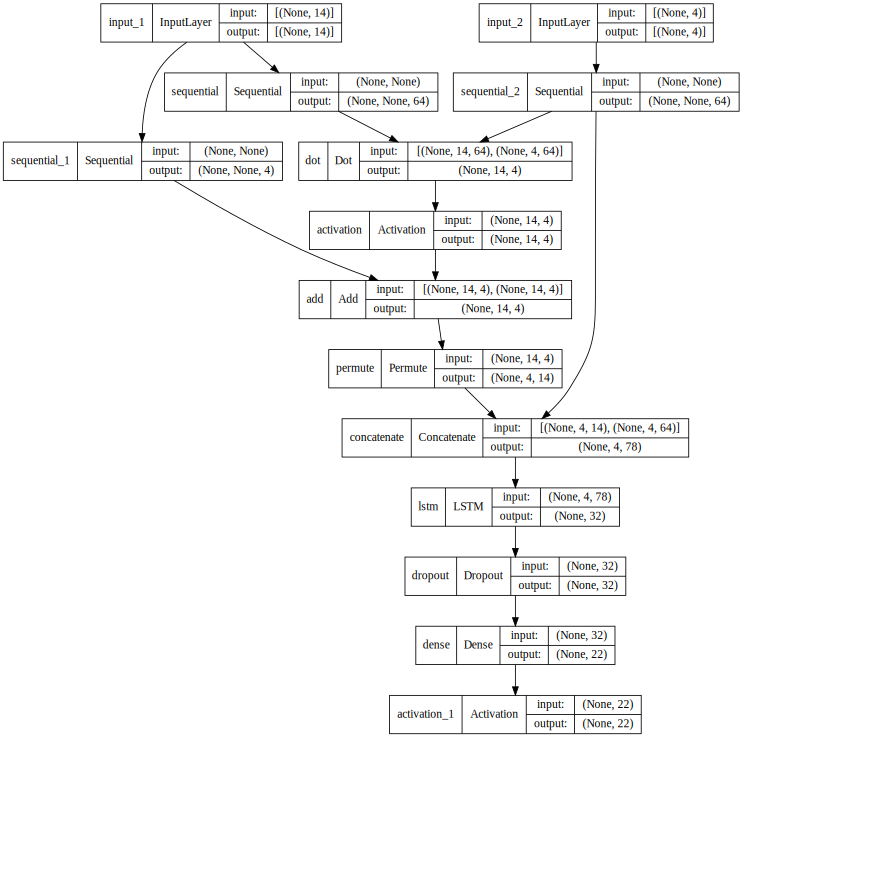

In [23]:
from IPython.display import SVG

SVG(tf.keras.utils.model_to_dot(model,show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

Model summary

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     1408        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, None, 64)     1408        ['input_2[0][0]']                
                                                                                              

## 1.5 Training

In this section we start the training procedure with fitting the data to the designed model.

In [25]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
          validation_data=([inputs_test, queries_test], answers_test))

model.save('model.h5')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


313/313 [==============================] - 24s 62ms/step - loss: 1.9478 - accuracy: 0.1679 - val_loss: 1.7957 - val_accuracy: 0.1870
Epoch 2/20
313/313 [==============================] - 19s 60ms/step - loss: 1.8040 - accuracy: 0.1747 - val_loss: 1.7893 - val_accuracy: 0.1990
Epoch 3/20
313/313 [==============================] - 20s 63ms/step - loss: 1.7847 - accuracy: 0.1959 - val_loss: 1.7737 - val_accuracy: 0.2610
Epoch 4/20
313/313 [==============================] - 19s 62ms/step - loss: 1.7783 - accuracy: 0.2031 - val_loss: 1.7701 - val_accuracy: 0.2150
Epoch 5/20
313/313 [==============================] - 20s 63ms/step - loss: 1.7761 - accuracy: 0.2081 - val_loss: 1.7745 - val_accuracy: 0.2240
Epoch 6/20
313/313 [==============================] - 20s 62ms/step - loss: 1.7724 - accuracy: 0.2223 - val_loss: 1.7620 - val_accuracy: 0.2570
Epoch 7/20
313/313 [==============================] - 20s 63ms/step - loss: 1.7659 - accuracy: 0.2319 - val_loss: 1.7522 - val_accuracy: 0.2550
Epo

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


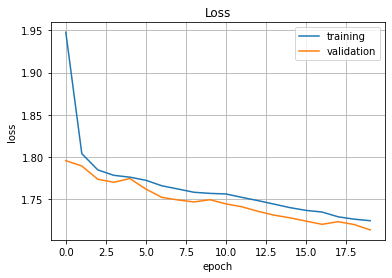

Min train loss is 1.724563479423523 at epoch 20
Min val loss is 1.713639259338379 at epoch 20



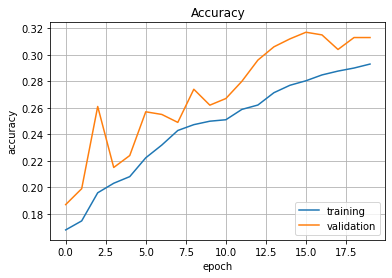

Max train accuracy is 0.2930000126361847 at epoch 20
Max val accuracy is 0.31700000166893005 at epoch 16


In [26]:
plot_loss(history,"Loss")
print()
plot_acc(history,"Accuracy")

## 1.6 Testing and Analysis

Now we need to actually make predictions and check the performance of our trained model with some examples:

In [27]:
for i in range(0,10):
    current_inp = test_stories[2*i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
    current_prediction = model.predict([current_story, current_query])
    current_prediction = idx_word[np.argmax(current_prediction)]
    print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
    print("-----------------------------------------------------------------------------------------")


John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: bathroom | Ground Truth: hallway
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Where is Sandra ? | Prediction: bathroom | Ground Truth: kitchen
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


John travelled to the hallway . Mary journeyed to the bathroom . Where is Sandra ? | Prediction: bathroom | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: hallway | Ground Truth: garden
-----------------------------------------------------------------------------------------
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: hallway | Ground Truth: office
-----------------------------------------------------------------------------------------
John travelled to the office . Mary journeyed to the kitchen . Where is Mary ? | Prediction: kitchen | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
John travelled to the office . Mary journeyed to the kitchen . Where is Daniel ? | Prediction: kitchen | Ground Truth: offi

## 1.7 Custom Inputs

You can even write your example and test it with your model to see how powerful it is:

In [35]:
print('-------------------------------------------------------------------------------------------')
print('Custom User Queries (Make sure there are spaces before each word)')

print('-------------------------------------------------------------------------------------------')
print('Please input a story')
user_story_inp = input().split(' ')
print('Please input a query')
user_query_inp = input().split(' ')
user_story, user_query, user_ans = vectorize_stories([[user_story_inp, user_query_inp, '.']], word_idx, story_maxlen, query_maxlen)
user_prediction = model.predict([user_story, user_query])
user_prediction = idx_word[np.argmax(user_prediction)]
print('Result')
print(' '.join(user_story_inp), ' '.join(user_query_inp), '| Prediction:', user_prediction)

-------------------------------------------------------------------------------------------
Custom User Queries (Make sure there are spaces before each word)
-------------------------------------------------------------------------------------------
Please input a story
Mary went to the bathroom . John moved to the hallway .
Please input a query
Where is Mary ?
Result
Mary went to the bathroom . John moved to the hallway . Where is Mary ? | Prediction: hallway


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [37]:
# some examples:
# Mary went to the bathroom . John moved to the hallway . Mary travelled to the office . # Where is Mary ?
# Sandra travelled to the office . John journeyed to the garden .
# Where is Sandra ?

As you understood how the model trained, please tell us about the pros and cons of the proposed model. How can we improve it if we want to use it in realistic task ? 

$\color{red}{\text{Write your answer in document}}$

